## 1. Of cats and cookies
<p><a href="https://www.facebook.com/cookiecatsgame">Cookie Cats</a> is a hugely popular mobile puzzle game developed by <a href="http://tactile.dk">Tactile Entertainment</a>. In this classic "connect three"-style puzzle game, tiles of the same color must be connected by the player to clear the board and win each level, accompanied by the entertaining feature of singing cats. A short demo showcases the game's unique elements.
<p>
As the levels progress, players will encounter gates intermittently, imposing a non-trivial waiting period or prompting an in-app purchase to advance. Beyond their role in driving in-app purchases, these gates fulfill the crucial function of mandating breaks for players, with the expectation that this interruption enhances and prolongs the player's overall enjoyment of the game.
<p>
Originally positioned at level 30, the first gate's location underwent modification in an AB-test discussed in this notebook, where it was shifted to level 40. The primary focus of the analysis is to examine the impact on player retention resulting from this adjustment. However, prior to delving into the analysis, a fundamental prerequisite is to comprehend the underlying data.







In [2]:

import pandas as pd
# Reading in the data
df = pd.read_csv('datasets/cookie_cats.csv')

df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## 2. The AB-test data
<p>The data  is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the group with the moved gate (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after install.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. As a sanity check, let's see if there are roughly the same number of players in each AB group. </p>

In [3]:
# Counting the number of players in each AB group.
df.groupby('version')['userid'].count()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

In [4]:
#df.groupby('version')['retention_1'].count()

## 3. The distribution of game rounds

<p>It looks like there is roughly the same number of players in each group, nice!</p>
<p>The focus of this analysis will be on how the gate placement affects player retention, At first, Let's plot the distribution of the number of game rounds players played during their first week playing the game.</p>

Text(0, 0.5, 'User Count')

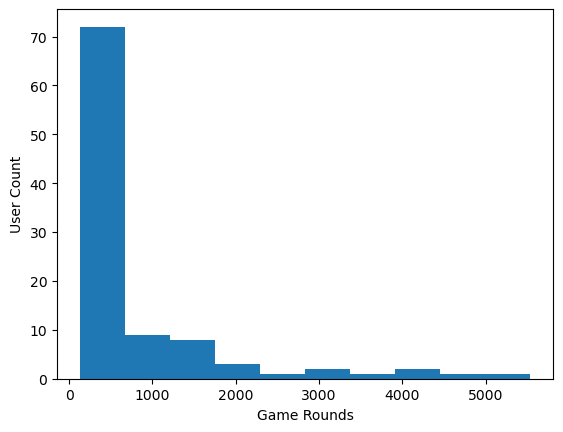

In [5]:
%matplotlib inline

# Counting the number of players for each number of gamerounds 
plot_df = df.groupby('sum_gamerounds')['userid'].count()
plot_df.head()


# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(n=100).plot(x="sum_gamerounds", y="userid", kind="hist")
ax.set_xlabel("Game Rounds")
ax.set_ylabel("User Count")

## 4. Overall 1-day retention

In the plot presented above, the observed player behavior varies: some individuals install the game but refrain from playing (0 game rounds), while others engage in a few game rounds during their initial week. Conversely, there are players who exhibit a strong level of engagement and become deeply involved with the game.
<p>
The ultimate objective is to foster player appreciation for the game and cultivate a sense of engagement. In the video gaming industry, a widely accepted metric for gauging the fun and engagement level of a game is 1-day retention. This metric represents the percentage of players who return and participate in the game one day after installing it. The higher the 1-day retention, the more effective the game is at retaining players and building a substantial player base.
<p>
As an initial exploration, let's examine the overall 1-day retention to gain insights into the game's initial appeal and the likelihood of retaining players shortly after installation.<p>

In [6]:
# The % of users that came back the day after they installed
df['retention_1'].mean()

0.4452095044850259

## 5. 1-day retention by AB-group

It's observed that slightly less than half of the players return one day after installing the game, establishing a baseline for 1-day retention. Now, with this benchmark in mind, the next step involves examining the variation in 1-day retention between the two AB groups.

In [7]:
# Calculating 1-day retention for each AB-group
df.groupby('version')['retention_1'].sum() / df.groupby('version')['userid'].count()

version
gate_30    0.448188
gate_40    0.442283
dtype: float64

In [8]:
 #df.groupby('version')['retention_7'].sum() /df.groupby('version')['userid'].count()

## 6. Should we be confident in the difference?
<p>The analysis reveals a marginal reduction in 1-day retention following the relocation of the gate to level 40 (44.2%) in comparison to the control condition, where it was situated at level 30 (44.8%). Despite the modest nature of this change, it is noteworthy that even minor adjustments in retention rates can carry substantial implications. However, while the observed variance in the data is evident, the question arises as to the level of certainty regarding the potential inferiority of 1-day retention with a gate at level 40 in the future.</p>
<p>To ascertain the confidence levels associated with these retention figures, a bootstrapping approach is employed. This method involves the iterative re-sampling of the dataset (with replacement), coupled with the calculation of 1-day retention for each sample. The resultant variability in 1-day retention across these samples serves as an indicator of the uncertainty surrounding the retention numbers.</p>

<Axes: ylabel='Density'>

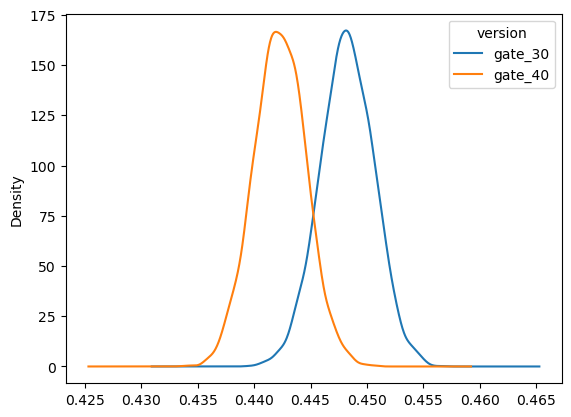

In [10]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(5000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot 
boot_1d.plot(kind='kde')

## 7. Zooming in on the difference

<p>The presented distributions above depict the bootstrap uncertainty surrounding the potential underlying 1-day retention for the two AB-groups. A visual inspection of the plot suggests the presence of some evidence indicating a difference, albeit subtle. To gain a closer examination of the variance, let's focus on the disparity in 1-day retention.</p>


Text(0.5, 0, '% difference in means')

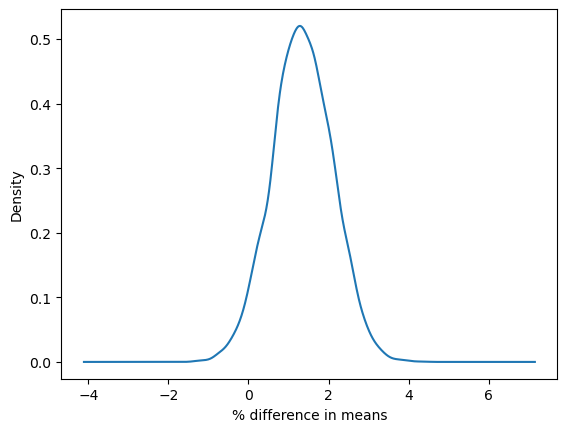

In [11]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d['gate_30'] - boot_1d['gate_40']) /  boot_1d['gate_40'] * 100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind = 'kde')
ax.set_xlabel("% difference in means")

## 8. The probability of a difference

<p>The chart indicates that the most probable percentage difference falls within the range of 1% to 2%, with the majority of the distribution favoring a gate at level 30, as evidenced by most values being above 0%. However, in order to quantify the likelihood that the difference is indeed above 0%, let's proceed with the calculation of this probability.</p>

In [12]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_1d['diff'] > 0).sum() / len(boot_1d)

# Pretty printing the probability
'{:.2%}'.format(prob)

'96.38%'

## 9. 7-day retention by AB-group

<p>The bootstrap analysis strongly suggests a high probability that 1-day retention is superior when the gate is positioned at level 30. However, considering the relatively short duration of players' engagement with the game (one day), it is plausible that a significant portion of players has not yet reached level 30. Consequently, the impact of the gate, even at level 30, may not have influenced a substantial proportion of players.</p>
<p>Given this context, an exploration of 7-day retention becomes pertinent. This metric assesses the percentage of individuals who installed the game and subsequently returned to play it a week later. The extended time frame of one week allows for a more comprehensive evaluation of player engagement, especially as more players would have likely reached level 40 during this period.</p>
<p>Let's initiate the analysis by calculating 7-day retention for the two AB-groups.</p>

In [13]:
# Calculating 7-day retention for both AB-groups
df.groupby('version')['retention_7'].sum() / df.groupby('version')['userid'].count()



version
gate_30    0.190201
gate_40    0.182000
dtype: float64

## 10. Bootstrapping the difference again
<p>Similar to the pattern observed in 1-day retention, 7-day retention exhibits a slight reduction (18.2%) when the gate is positioned at level 40, compared to the scenario where the gate is at level 30 (19.0%). Notably, this difference surpasses the magnitude observed in 1-day retention, presumably attributable to the increased likelihood of players reaching the first gate within the extended timeframe of a week. Additionally, it is noteworthy that the overall 7-day retention is lower in comparison to the overall 1-day retention, indicating a decline in player engagement over the one-week period following installation.</p>
<p>As previously undertaken, let's employ bootstrap analysis to ascertain the level of certainty regarding the difference between the AB-groups in terms of 7-day retention.</p>

'99.9%'

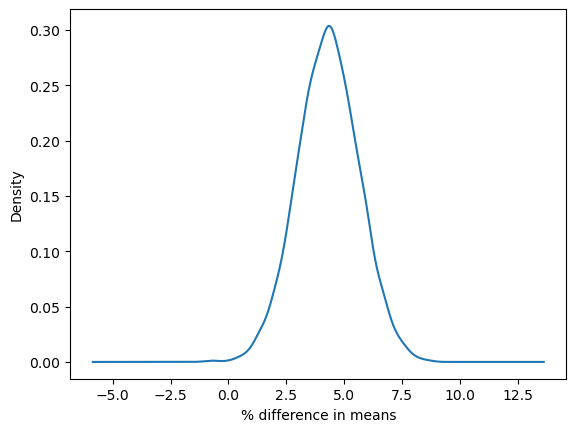

In [14]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(5000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) /  boot_7d['gate_30'] * 100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind = 'kde')
ax.set_xlabel("% difference in means")

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff'] > 0).sum() / len(boot_7d)

# Pretty printing the probability
'{:.1%}'.format(prob)

## 11.  The conclusion
<p>The results from the bootstrap analysis strongly indicate that there is compelling evidence supporting higher 7-day retention when the gate is positioned at level 30 as opposed to level 40. Consequently, the overarching conclusion suggests that, to maintain high levels of retention—both in terms of 1-day and 7-day metrics—it is advisable <strong>not</strong> to relocate the gate from level 30 to level 40. While there exist other metrics such as the number of game rounds played or the extent of in-game purchases by the two AB-groups, retention remains a paramount metric. The rationale is straightforward: without a retained player base, the financial contributions made within the game become inconsequential.</p>
<p>Curiously, the question arises: Why is retention higher when the gate is positioned earlier? Contrary to the intuitive expectation that a later obstacle might prolong engagement, the data suggests otherwise. The theory of <em>hedonic adaptation</em> provides a potential explanation for this phenomenon. In essence, hedonic adaptation posits that individuals derive diminishing enjoyment from a continuous engagement in a pleasurable activity over time. By introducing a break for players upon encountering a gate, their enjoyment of the game is prolonged. Conversely, when the gate is deferred to level 40, fewer players advance to this stage, increasing the likelihood of disengagement due to boredom.</p>

So, given the data and the bootstrap analysis we shouldn't move the gate from level 30 to level 40!!
